## 教師なしの機械学習モデルでもscikit-learnのgridsearchCVが使いたかったので自作してみた

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import*
import matplotlib.animation as anm
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
class UnsupervisedKernelRegression(BaseEstimator, TransformerMixin):
    def __init__(self, latent_dim=2, learning_rate=0.5, sigma=1.0, lambda_=1e-3):
        self.X = None
        self.X_pred = None
        self.Z = None
        self.n_sample = None
        self.input_dim = None
        self.latent_dim = latent_dim
        self.sigma = 1.0   # カーネルの幅を決定する定数
        self.gamma = 1.0 / (self.sigma **2)
        self.lambda_ = lambda_   # 正則化項の強さを決定する定数
        self.learning_rate = learning_rate   # 勾配法の学習率
        self.history = None   # 学習結果を保存する辞書
    
    def fit(self, X, n_epoch=100):
        self.X = X
        self.n_sample = X.shape[0]
        self.input_dim = X.shape[1]
        self.Z = np.random.normal(loc=0, scale=1e-3, size=(self.n_sample, self.latent_dim))
        self.history = {
            "Z": np.zeros((n_epoch, self.n_sample, self.latent_dim)),
            "X_pred": np.zeros((n_epoch, self.n_sample, self.input_dim))
        }
        
        for epoch in range(n_epoch):
            self.delta = self.Z[:,None,:] - self.Z[None,:,:]
            self.h_kn = np.exp(-1 / (2*self.sigma ** 2) * np.sum((self.Z[None, :, :] - self.Z[:, None, :]) ** 2,axis=2))
            self.g_k = np.sum(self.h_kn,axis=1)
            self.r_ij = self.h_kn/self.g_k[:,None]
            self.X_pred = self.r_ij @ self.X
            self.d_ij = self.X_pred[:, None, :] - self.X[None, :, :]
            self.A = self.gamma * self.r_ij * np.einsum('nd,nid->ni', self.X_pred - self.X, self.d_ij)
            self.bibun = np.sum((self.A + self.A.T)[:, :, None] * self.delta, axis=1)
            self.Z -= self.learning_rate * (self.bibun + self.lambda_*self.Z)
            # 学習結果を保存する
            self.history["Z"][epoch] = self.Z
            self.history["X_pred"][epoch] = self.X_pred
    
    def reconstruction_loss(self, X_true, X_pred):
        N = X_true.shape[0]
        dist = X_pred - X_true
        loss = 0.5 * np.sum(dist ** 2) / N
        return loss

In [3]:
n_sample = 200   # データ数
n_epoch=500   # 学習回数

# 学習データは，3次元のサドルシェイプデータを使用する
# 加えて，１０次元のノイズは加えておく
X = np.random.normal(loc=0, scale=0.1, size=(n_sample, 10))
data = np.random.rand(n_sample, 2) * 2 - 1
X[:, 0] += data[:, 0]
X[:, 1] += data[:, 1]
X[:, 2] += data[:, 0] ** 2 - data[:, 1] ** 2

# 今回テストで使用する教師なしの機械学習モデル（通称UKR）
# 観測データXに対応する低次元の潜在変数Zと非線形な滑らかな写像f: Z→Xの２種類を学習する
# 大雑把にいうと，　非線形のPCAやGPLVM
model = UnsupervisedKernelRegression()

# 今回変えるパラメータを辞書で登録する
# このパラメータは各自が用意したモデルの__init__の引数によって変える
# パラメータはスカラー値のものしか指定できないことに注意
params = {
    'latent_dim':  [1, 2, 3],   # 潜在空間の次元数
    'learning_rate': [1000, 100, 10, 1, 0.1],   # 勾配法の学習率
}

# gridsearchでパラメータの良し悪しを判断するための評価関数
# 返り値はスカラーのスコア値にする
# ここでは，単純にUKRの目的関数（学習データの復元誤差）を評価関数に使用する
def scorer(model, X):
    score = model.reconstruction_loss(
        X_true=X,
        X_pred=model.X_pred
    )
    return score

# GridSearchCVの設定
# 教師なしのため，　CrossValidationは全くしないことに注意
gs = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring=scorer,
    cv=[(slice(None), slice(None))],
    verbose=1,
    n_jobs=3,
)

# グリッドサーチを実行する
# 教師なしなので， yはNoneを指定する
# UKR.fitの引数もここで指定できる一方で，　Xとyは必ず指定しないといけないことに注意する
gs.fit(X=X, y=None, n_epoch=n_epoch)

# パラメータとそのパラメータで学習したときのスコア値を表示する
for param, score in zip(gs.cv_results_['params'], gs.cv_results_['mean_test_score']):
    print(f'score:{score:.3f} param: {param}')

Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   11.2s finished


score:0.237 param: {'latent_dim': 1, 'learning_rate': 1000}
score:0.261 param: {'latent_dim': 1, 'learning_rate': 100}
score:0.079 param: {'latent_dim': 1, 'learning_rate': 10}
score:0.072 param: {'latent_dim': 1, 'learning_rate': 1}
score:0.139 param: {'latent_dim': 1, 'learning_rate': 0.1}
score:0.283 param: {'latent_dim': 2, 'learning_rate': 1000}
score:0.010 param: {'latent_dim': 2, 'learning_rate': 100}
score:0.024 param: {'latent_dim': 2, 'learning_rate': 10}
score:0.029 param: {'latent_dim': 2, 'learning_rate': 1}
score:0.052 param: {'latent_dim': 2, 'learning_rate': 0.1}
score:0.211 param: {'latent_dim': 3, 'learning_rate': 1000}
score:0.003 param: {'latent_dim': 3, 'learning_rate': 100}
score:0.006 param: {'latent_dim': 3, 'learning_rate': 10}
score:0.009 param: {'latent_dim': 3, 'learning_rate': 1}
score:0.051 param: {'latent_dim': 3, 'learning_rate': 0.1}


In [4]:
# 平行座標表示でパラメータとスコアを可視化する
import pandas as pd
df = pd.DataFrame(gs.cv_results_['params'])
df['loss'] = gs.cv_results_['mean_test_score']

import plotly.graph_objects as go
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
et = list(df['learning_rate'])
le.fit(et)
et_le = le.transform(et)

fig = go.Figure(
    data=go.Parcoords(
        line=dict(color=df['loss'],
                  colorscale='Bluered_r',
                  showscale=True),
        dimensions=list([
            dict(label='latent_dim',
                values=df['latent_dim']),
            dict(tickvals=le.transform(np.sort(list(set(df['learning_rate'])))),
                ticktext=np.sort(list(set(df['learning_rate']))),
                label="learning_rate",
                values=et_le),
            dict(range=[0, max(df['loss'])],
                label='ukr_loss',
                values=df['loss'])
        ])
    )
)
fig.show()

<IPython.core.display.Javascript object>


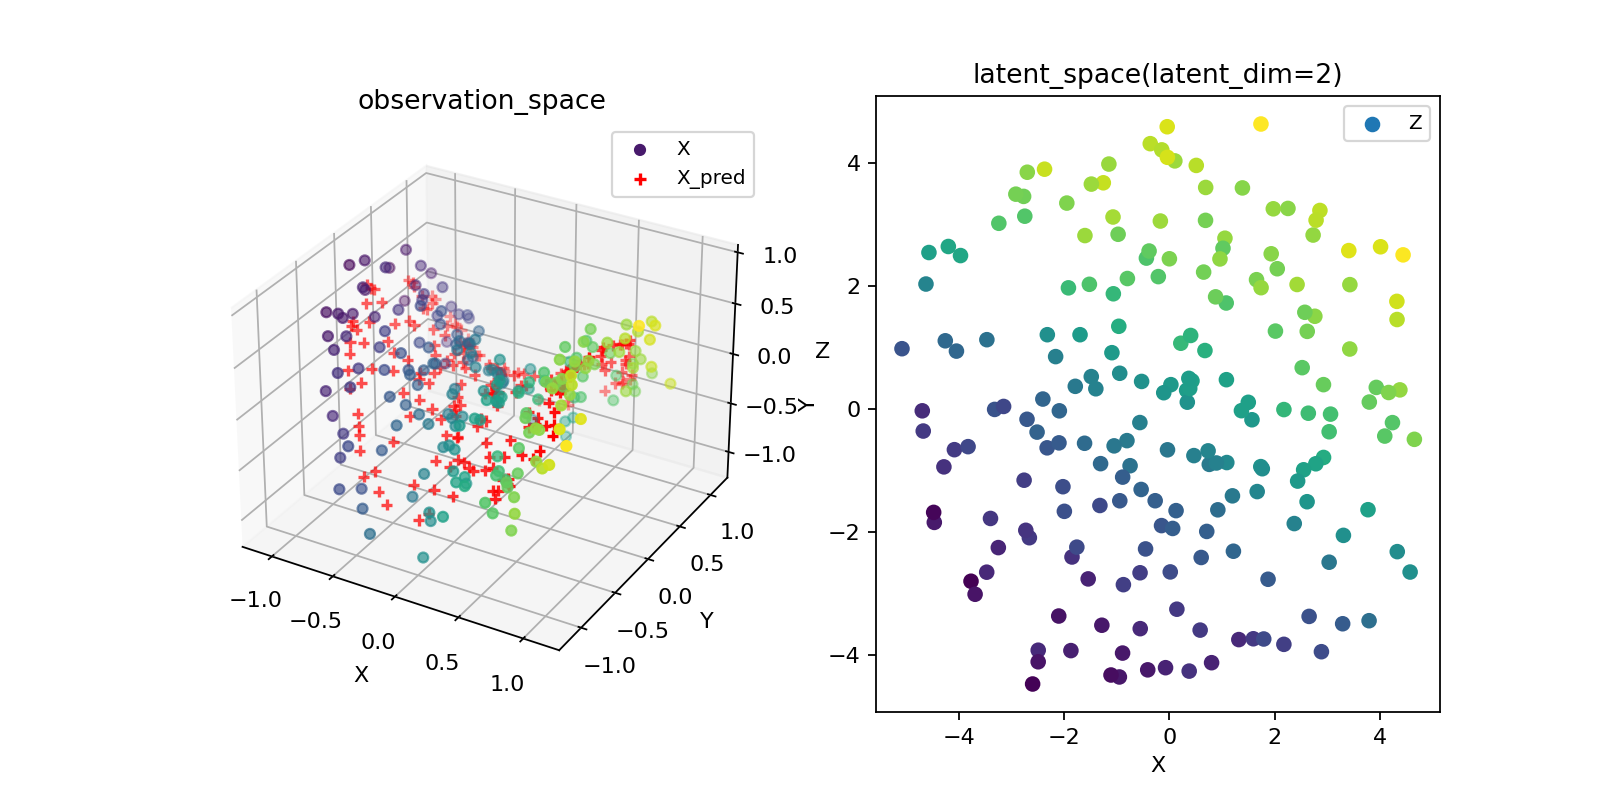

In [9]:
%matplotlib nbagg
# gridsearchでlossが低かったパラメータを選んで実際に学習結果を可視化してみる
model = UnsupervisedKernelRegression(latent_dim=2, learning_rate=1)
model.fit(X=X, n_epoch=n_epoch)

# 描画
fig = plt.figure(1,figsize=(10, 5))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
X_pred = model.history["X_pred"]
Z = model.history["Z"]

def update(i):
    ax1.cla()
    ax2.cla()
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 0], label='X')
    ax1.scatter(X_pred[i, :, 0], X_pred[i, :, 1], X_pred[i, :, 2], color='red', s=25, marker='+', label='X_pred')
    ax2.scatter(Z[i, :, 0], Z[i, :, 1], c=X[:, 0], label='Z')
    ax1.set_title('observation_space', fontsize=12)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax2.set_title('latent_space(latent_dim=2)', fontsize=12)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax1.legend(fontsize=9)
    ax2.legend(fontsize=9)
ani = anm.FuncAnimation(fig, update, interval=200, frames=n_epoch)
plt.show()

<IPython.core.display.Javascript object>


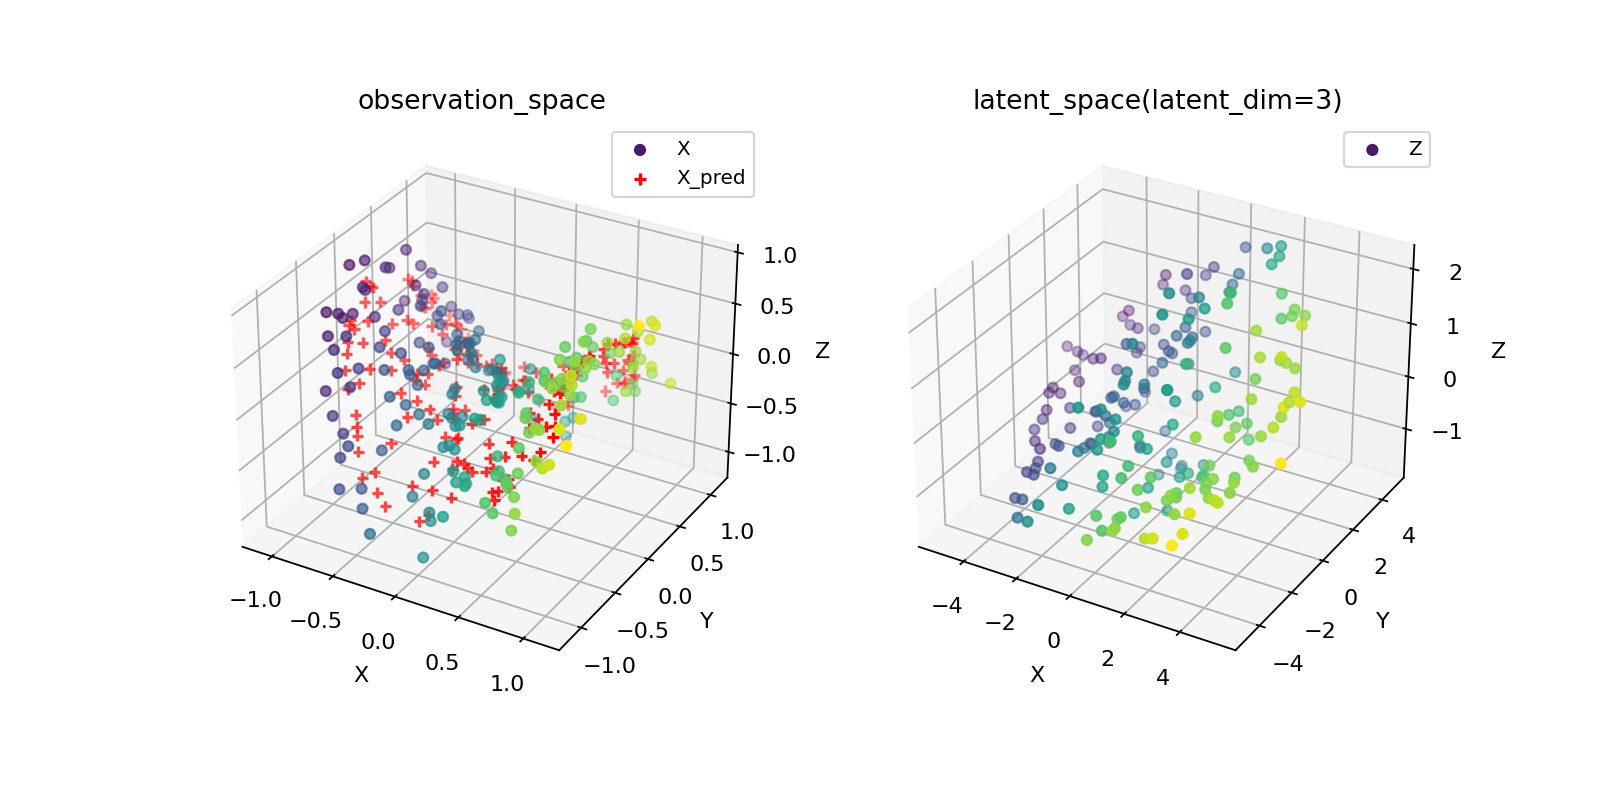

In [10]:
%matplotlib nbagg
# gridsearchでlossが低かったパラメータを選んで実際に学習結果を可視化してみる
model = UnsupervisedKernelRegression(latent_dim=3, learning_rate=1)
model.fit(X=X, n_epoch=n_epoch)

# 描画
fig = plt.figure(1,figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
X_pred = model.history["X_pred"]
Z = model.history["Z"]
def update(i):
    ax1.cla()
    ax2.cla()
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 0], label='X')
    ax1.scatter(X_pred[i, :, 0], X_pred[i, :, 1], X_pred[i, :, 2], color='red', s=25, marker='+', label='X_pred')
    ax2.scatter(Z[i, :, 0], Z[i, :,1], Z[i, :, 2], c=X[:,0], label='Z')
    ax1.set_title('observation_space', fontsize=12)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax2.set_title('latent_space(latent_dim=3)', fontsize=12)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax1.legend(fontsize=9)
    ax2.legend(fontsize=9)
ani = anm.FuncAnimation(fig, update, interval=200, frames=n_epoch)
plt.show()